# GLRT CI Coverage

In [9]:
# Comparing the analytic GLRT for the single-coefficient case with the optimization-based version
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [10]:
from uncertainty.DataGeneration import linearRegression_normal
from uncertainty.torch_linear import TorchLinear
from uncertainty.analyticLinearRegressionCIs import analyticLinearTest_GLRT, analyticLinearCis
from uncertainty.glrtTorch import glrtTorchCis
from uncertainty.torch_linear import TorchLinear

In [4]:
def compareAnalyticVsOptimization(beta, n=200, alpha=0.05):
    """Generate data according to a linear regression with coefficient vector beta.
    Compute the analytic chi-squared test 'is the coefficient vector zero?'. Record the p-value.
    Compute the confidence intervals on beta using the GLRT-based method. Record whether ALL intervals contains zero.
    Return TRUE if both methods agree, and FALSE otherwise."""  
    # Get data
    X, y = linearRegression_normal(beta=np.array(beta), cov=np.eye(len(beta)), sigma=1, n=n)

    # Compute the p-value from the chi squared test
    TL = TorchLinear(lr=0.3,max_iter=30)
    TL.fit(X,y)
    pVal_TL = analyticLinearTest_GLRT(TL, X, y)
    
    # Next, get the optimization-based intervals.
    # GLRT method with Torch model (coefs)
    lcb_GLRT, ucb_GLRT, lcb_Results, ucb_Results, ucb_Torch = glrtTorchCis(
        lambda:TorchLinear(lr=0.3,max_iter=100,fit_intercept=False), X=X, y=y, citype='coefs', alpha=alpha,
        search_kwargs={'lmbds':np.logspace(-10,10,101)},fit_kwargs={'lr':0.3,'max_iter':30})
    
    
    # To check whether they agree with the analytic version:
    # The p-value should be < 0.05 iff any of the level-0.05 glrt-based confidence intervals
    # on the coefficient beta don't contain zero.
    isNotZero_analytic = pVal_TL < alpha    # The chi-square test is one-sided
    isNotZero_optim = any(lcb_GLRT > 0) or any(ucb_GLRT < 0)
    
    print("p value", pVal_TL, "and confidence interval(s)", lcb_GLRT, "to", ucb_GLRT)
    
    return (isNotZero_analytic == isNotZero_optim, pVal_TL, lcb_GLRT, ucb_GLRT)


## See whether the analytic single-dimensional confidence intervals also suffer from over-coverage

In [20]:
# Multi-dimensional nonzero coefficient
reps=100
n=200
alpha=0.05

for d in [2, 5, 10]:
    print(d)
    equiv = []
    pVals = []
    lcbs = []
    ucbs = []
    lcbs_a = []
    ucbs_a = []

    betas = []
    covered_a = []

    for i in range(reps):
        beta = np.array(np.random.normal(loc=bmean,scale=bstd, size=d))
        # Get data
        X, y = linearRegression_normal(beta=beta, cov=np.eye(len(beta)), sigma=1, n=n)

        # Get the analytic linear model confidence intervals on each coefficient individually, to see if
        # we have overcoverage there as well.
        TL = TorchLinear(lr=0.3,max_iter=30)
        TL.fit(X,y)
        lcb_a, ucb_a = analyticLinearCis(TL, X, y, alpha=alpha, fitIntercept=False)

        betas.append(beta)
        covered_a.append((lcb_a<=beta) & (beta<=ucb_a))
        
    print("Coverage:", np.mean(covered_a))

2
Coverage: 0.96
5
Coverage: 0.958
10
Coverage: 0.945


## Single nonzero coefficient

In [5]:
%%time
bmean, bstd = 0,1
reps = 100

equiv = []
pVals = []
lcbs = []
ucbs = []

betas = []
covered = []

#for i in range(1000):
for i in range(reps):
    beta = np.random.normal(loc=bmean,scale=bstd)
    s, p, l, u = compareAnalyticVsOptimization(beta=[beta])
    equiv.append(s)
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)
    
    betas.append(beta)
    covered.append(l[0]<=beta<=u[0])

p value 0.0 and confidence interval(s) [-0.87920702] to [-0.63185334]
Analytic confidence intervals [-0.89453152] to [-0.61038789]
p value 0.0 and confidence interval(s) [-1.00905919] to [-0.7695893]
Analytic confidence intervals [-0.99447953] to [-0.73453355]
p value 0.7688752746428834 and confidence interval(s) [-0.14303221] to [0.10050575]
Analytic confidence intervals [-0.16744825] to [0.11794049]
p value 1.1263212584822213e-12 and confidence interval(s) [-0.68104726] to [-0.4134213]
Analytic confidence intervals [-0.69537463] to [-0.39199982]
p value 0.0 and confidence interval(s) [-1.7950021] to [-1.5789417]
Analytic confidence intervals [-1.80632844] to [-1.5443202]
p value 0.002588467088285862 and confidence interval(s) [-0.32456762] to [-0.09611872]
Analytic confidence intervals [-0.34586225] to [-0.07051234]
p value 0.0 and confidence interval(s) [-1.12217176] to [-0.9485631]
Analytic confidence intervals [-1.17031286] to [-0.90112951]
p value 0.0 and confidence interval(s) [

p value 0.001050989290531934 and confidence interval(s) [0.15520005] to [0.32569557]
Analytic confidence intervals [0.09202928] to [0.38145476]
p value 0.0 and confidence interval(s) [0.59420037] to [0.8515116]
Analytic confidence intervals [0.57745353] to [0.85501536]
p value 0.03218864960039147 and confidence interval(s) [-0.26539341] to [-0.03664628]
Analytic confidence intervals [-0.28990778] to [-0.0118534]
p value 0.0 and confidence interval(s) [-1.86205828] to [-1.62207747]
Analytic confidence intervals [-1.88700177] to [-1.5998771]
p value 0.6237740068092572 and confidence interval(s) [-0.14070144] to [0.07732947]
Analytic confidence intervals [-0.15347909] to [0.10129052]
p value 0.0 and confidence interval(s) [1.13075435] to [1.32103753]
Analytic confidence intervals [1.07673109] to [1.37711966]
p value 3.0125399952396492e-09 and confidence interval(s) [0.27727327] to [0.52269411]
Analytic confidence intervals [0.26487621] to [0.53085563]
p value 0.0 and confidence interval(s

In [ ]:
print(f'Coverage: {np.mean(covered)}')

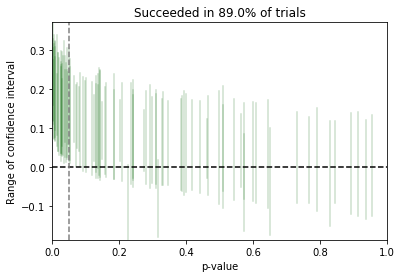

In [5]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Single Zero Coefficient

In [6]:
%%time
beta = 0.0

success = []
pVals = []
lcbs = []
ucbs = []

#for i in range(1000):
for i in range(100):
    s, p, l, u = compareAnalyticVsOptimization(beta=beta)
    success.append(s[0])
    pVals.append(p)
    lcbs.append(l)
    ucbs.append(u)

p value 0.010065697013278752 and confidence interval [-0.32121551] to [-0.05462781]
p value 0.38332014773572665 and confidence interval [-0.18513457] to [0.0566593]
p value 0.46933716149415605 and confidence interval [-0.17649673] to [0.07245571]
p value 0.40162140227533727 and confidence interval [-0.06663625] to [0.17793277]
p value 0.13307229248481245 and confidence interval [-0.01165634] to [0.20390682]
p value 0.9251746992055117 and confidence interval [-0.09618982] to [0.08314887]
p value 0.9492197278954458 and confidence interval [-0.13533084] to [0.14375989]
p value 0.6220876893032526 and confidence interval [-0.17182997] to [0.1003686]
p value 0.2971460329040737 and confidence interval [-0.05243973] to [0.20746814]
p value 0.7509762379159894 and confidence interval [-0.15082262] to [0.10511569]
p value 0.8686630493086943 and confidence interval [-0.1364222] to [0.11374637]
p value 0.12406568351362302 and confidence interval [-0.19133796] to [-0.02761748]
p value 0.694166183241

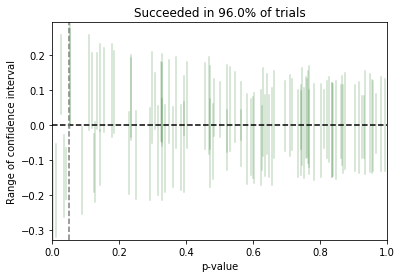

In [7]:
minY = min(lcbs)
maxY = max(ucbs)
plt.ylim(minY, maxY)

for (p, l, u, s) in zip(pVals, lcbs, ucbs, success):
    # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
    plt.axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                color=('darkgreen' if s else 'darkred'), alpha=0.2)

# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(lcbs)[np.array(success)], color='darkgreen')
# plt.scatter(np.asarray(pVals)[np.array(success)], np.asarray(ucbs)[np.array(success)], color='darkgreen')

# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(lcbs)[~np.array(success)], color='darkred', marker='x')
# plt.scatter(np.asarray(pVals)[~np.array(success)], np.asarray(ucbs)[~np.array(success)], color='darkred', marker='x')

plt.axhline(0, color='k', linestyle='--')
plt.axvline(0.05, color='gray', linestyle='--')

plt.xlabel("p-value")
plt.ylabel("Range of confidence interval")
plt.title("Succeeded in " + str(np.mean(success)*100) + "% of trials")

plt.show()

## Multidimensional Zero Coefficient

2
p value 0.5756805038578596 and confidence interval(s) [-0.18556319 -0.12919495] to [0.03998545 0.16042283]
Analytic confidence intervals [-0.21182781 -0.14320798] to [0.06845374 0.17439684]
p value 0.5324513919572269 and confidence interval(s) [-0.03943546 -0.12013558] to [0.1968475  0.13644594]
Analytic confidence intervals [-0.06040487 -0.14063373] to [0.21633105 0.14774417]
p value 0.23095248876384233 and confidence interval(s) [-0.19225864 -0.01801663] to [0.06551693 0.26103297]
Analytic confidence intervals [-0.20740688 -0.02602587] to [0.07956737 0.27255558]
p value 0.9480977543193809 and confidence interval(s) [-0.15075307 -0.09295995] to [0.10959253 0.1114287 ]
Analytic confidence intervals [-0.15738048 -0.11162591] to [0.12306879 0.13686338]
p value 0.9000047283158765 and confidence interval(s) [-0.15072708 -0.12741776] to [0.09007874 0.10555838]
Analytic confidence intervals [-0.17012538 -0.14908728] to [0.1114186  0.12784173]
p value 0.35474407735742486 and confidence inte

p value 0.3919880483766459 and confidence interval(s) [-0.15140551 -0.24351928] to [0.08259031 0.04234935]
Analytic confidence intervals [-0.17446795 -0.26139452] to [0.10256731 0.04481184]
p value 0.20945023311731248 and confidence interval(s) [-0.10774741  0.0009347 ] to [0.14512114 0.2458411 ]
Analytic confidence intervals [-0.12302171 -0.01607913] to [0.1602331  0.26268058]
p value 0.24985245965131186 and confidence interval(s) [-0.17950156 -0.01812433] to [0.05554583 0.20462446]
Analytic confidence intervals [-0.19915018 -0.05202218] to [0.07690274 0.21671162]
p value 0.7934495921015907 and confidence interval(s) [-0.07969321 -0.12755662] to [0.1812644  0.14361902]
Analytic confidence intervals [-0.10048805 -0.14356117] to [0.19931399 0.16205406]
p value 0.40353054938148825 and confidence interval(s) [-0.04151578 -0.15280612] to [0.20341824 0.06564513]
Analytic confidence intervals [-0.05285181 -0.17147635] to [0.21304285 0.07963264]
p value 0.23522666623414346 and confidence inte

p value 0.7494067873757619 and confidence interval(s) [-0.16211861 -0.17134066] to [0.10387155 0.07372084]
Analytic confidence intervals [-0.18154664 -0.19608552] to [0.12259744 0.09584812]
p value 0.02384085774111 and confidence interval(s) [-0.23645638 -0.3031809 ] to [ 0.03316295 -0.03057286]
Analytic confidence intervals [-0.23069286 -0.30753768] to [ 0.04238152 -0.03295397]
p value 0.24675706982371703 and confidence interval(s) [-0.19210112 -0.23593599] to [0.05633815 0.04173024]
Analytic confidence intervals [-0.1954106  -0.23148027] to [0.06669537 0.04561445]
p value 0.9588763909225176 and confidence interval(s) [-0.11401412 -0.1257728 ] to [0.15463981 0.13941082]
Analytic confidence intervals [-0.12987585 -0.14227519] to [0.17043798 0.1560927 ]
p value 0.7611546172142474 and confidence interval(s) [-0.17910084 -0.10893334] to [0.09411682 0.17354436]
Analytic confidence intervals [-0.18492534 -0.11303433] to [0.09703541 0.17366481]
p value 0.688739162592025 and confidence interv

p value 0.3243073352051602 and confidence interval(s) [-0.13644558 -0.23853326] to [0.09782121 0.05886707]
Analytic confidence intervals [-0.15518452 -0.20665371] to [0.11409773 0.03434969]
p value 0.7326763759587754 and confidence interval(s) [-0.17759708 -0.10269134] to [0.10168781 0.19248798]
Analytic confidence intervals [-0.17672557 -0.0925592 ] to [0.10774894 0.19989821]
p value 0.5681777941816838 and confidence interval(s) [-0.21784244 -0.14512053] to [0.06322403 0.14775698]
Analytic confidence intervals [-0.22016803 -0.14464216] to [0.0690583  0.15059863]
p value 0.7979948025808683 and confidence interval(s) [-0.15636855 -0.09906714] to [0.09639785 0.16251732]
Analytic confidence intervals [-0.15669505 -0.08417102] to [0.09492923 0.17180473]
p value 0.8405566792347481 and confidence interval(s) [-0.16298471 -0.08537932] to [0.11817189 0.15513748]
Analytic confidence intervals [-0.16153352 -0.09307723] to [0.11575358 0.16338785]
p value 0.8723698844234462 and confidence interval

p value 0.35246025608510245 and confidence interval(s) [-0.06660265 -0.2002656 ] to [0.1689698  0.03316641]
Analytic confidence intervals [-0.07707755 -0.22209255] to [0.19786215 0.0515952 ]
p value 0.5331413903796485 and confidence interval(s) [-0.06684649 -0.11361087] to [0.20635538 0.18029547]
Analytic confidence intervals [-0.06930131 -0.10951156] to [0.20794859 0.17805217]
p value 0.39613945932982486 and confidence interval(s) [-0.05260343 -0.1629902 ] to [0.23166627 0.0750343 ]
Analytic confidence intervals [-0.06388262 -0.18299899] to [0.24223434 0.09711381]
p value 0.4478370422535799 and confidence interval(s) [-0.19221988 -0.11880592] to [0.0244348  0.13235602]
Analytic confidence intervals [-0.21840132 -0.13406473] to [0.04960845 0.15450013]
p value 0.5940783750894127 and confidence interval(s) [-0.18885218 -0.17634661] to [0.13472044 0.04348343]
Analytic confidence intervals [-0.16013223 -0.20585451] to [0.10646468 0.07078405]
p value 0.6046034489460694 and confidence interv

p value 0.9540260357577636 and confidence interval(s) [-0.14395638 -0.1471608 ] to [0.14097601 0.10239755]
Analytic confidence intervals [-0.15444773 -0.15480788] to [0.15616545 0.1358854 ]
p value 0.4128106774160364 and confidence interval(s) [-0.05703477 -0.072579  ] to [0.17364562 0.19898529]
Analytic confidence intervals [-0.06178648 -0.06719557] to [0.17839978 0.19340728]
p value 0.6021818498595577 and confidence interval(s) [-0.14182493 -0.06666442] to [0.09806963 0.1980498 ]
Analytic confidence intervals [-0.15189577 -0.0708062 ] to [0.10805491 0.20226092]
p value 0.166466551379866 and confidence interval(s) [-0.11107672  0.00498715] to [0.11972374 0.26844528]
Analytic confidence intervals [-0.12921451 -0.00563878] to [0.13751356 0.27933583]
p value 0.13543405882516657 and confidence interval(s) [-0.25867271 -0.26401252] to [0.06906769 0.04548942]
Analytic confidence intervals [-0.22436511 -0.27014987] to [0.03757944 0.05031175]
p value 0.31923065442238696 and confidence interva

p value 0.037911080367577954 and confidence interval(s) [-0.14341472  0.01237901] to [0.12107292 0.37511897]
Analytic confidence intervals [-0.17443564  0.05089149] to [0.14706435 0.34996366]
p value 0.0916411810253338 and confidence interval(s) [-0.20112523 -0.00539785] to [0.06351995 0.2425154 ]
Analytic confidence intervals [-0.1988818  -0.00710738] to [0.061063   0.24448583]
p value 0.6295416777258329 and confidence interval(s) [-0.17959099 -0.16562372] to [0.08869916 0.09223764]
Analytic confidence intervals [-0.18169018 -0.16981658] to [0.09144108 0.09795354]
p value 0.8438829982852257 and confidence interval(s) [-0.13402843 -0.15715417] to [0.11055271 0.07897437]
Analytic confidence intervals [-0.14970649 -0.17114852] to [0.12538652 0.09914919]
p value 0.3513333758536894 and confidence interval(s) [-0.15171753 -0.03116184] to [0.12573969 0.23479588]
Analytic confidence intervals [-0.15417195 -0.04344323] to [0.13138606 0.23613451]
p value 0.6118488155704767 and confidence interv

p value 0.06574831699286532 and confidence interval(s) [-0.19986719  0.02251523] to [0.06449421 0.27869612]
Analytic confidence intervals [-0.20744002  0.0134967 ] to [0.07233284 0.28890686]
p value 0.1612110725281024 and confidence interval(s) [-0.16999112 -0.0092487 ] to [0.07159431 0.26168725]
Analytic confidence intervals [-0.17987724 -0.01568304] to [0.08656331 0.26647882]
p value 0.2865683417949121 and confidence interval(s) [-0.06100347 -0.03174484] to [0.20931703 0.24783394]
Analytic confidence intervals [-0.0789221  -0.04456911] to [0.23120522 0.27082433]
p value 0.32074617185238063 and confidence interval(s) [-0.08855477 -0.11359528] to [0.29494962 0.15834445]
Analytic confidence intervals [-0.03668976 -0.12355752] to [0.23834205 0.16800663]
p value 0.44355370121499627 and confidence interval(s) [-0.24008058 -0.09032976] to [0.07921991 0.19637406]
Analytic confidence intervals [-0.24000533 -0.07875759] to [0.05855108 0.20414912]
p value 0.9234881611259531 and confidence inter

p value 0.3220014153770656 and confidence interval(s) [-0.18801519 -0.1986372 ] to [0.09358138 0.0202497 ]
Analytic confidence intervals [-0.19343022 -0.21879481] to [0.1002727  0.04014838]
p value 0.14811608570714352 and confidence interval(s) [-0.23927476 -0.18986329] to [0.01172402 0.04647039]
Analytic confidence intervals [-0.26092737 -0.22276948] to [0.0190487  0.04890442]
p value 0.551847788148315 and confidence interval(s) [-0.18591632 -0.18247107] to [0.09050456 0.05863645]
Analytic confidence intervals [-0.19632368 -0.20683744] to [0.10053782 0.07041406]
p value 0.15941507153720047 and confidence interval(s) [-0.10643217 -0.250386  ] to [ 0.1584677  -0.00774622]
Analytic confidence intervals [-0.12196494 -0.2664908 ] to [0.17115677 0.01404487]
p value 0.5486729079547801 and confidence interval(s) [-0.04818296 -0.12629576] to [0.19946641 0.11341958]
Analytic confidence intervals [-0.06278406 -0.14248153] to [0.21320893 0.12905443]
p value 0.6438471797633609 and confidence inter

p value 0.2887781765482005 and confidence interval(s) [-0.21163577 -0.19718561] to [0.01210908 0.07681297]
Analytic confidence intervals [-0.2354932  -0.20973594] to [0.03513769 0.08974896]
p value 0.6460516687580753 and confidence interval(s) [-0.07406295 -0.18003567] to [0.16404684 0.08351069]
Analytic confidence intervals [-0.08151452 -0.183997  ] to [0.17391351 0.08472818]
p value 0.5743109825443495 and confidence interval(s) [-0.17394803 -0.21504584] to [0.12735738 0.05363849]
Analytic confidence intervals [-0.18832925 -0.23734603] to [0.13617215 0.06908608]
p value 0.6986898336282527 and confidence interval(s) [-0.20244649 -0.11355295] to [0.07836889 0.10698998]
Analytic confidence intervals [-0.20673604 -0.13153726] to [0.08224226 0.12455789]
p value 0.47765715035542344 and confidence interval(s) [-0.16130629 -0.20230162] to [0.10783035 0.05203401]
Analytic confidence intervals [-0.16465524 -0.20024893] to [0.09685793 0.05397167]
p value 0.6432513975003467 and confidence interva

p value 0.2675227170322029 and confidence interval(s) [-0.0465638  -0.18353233] to [0.22405393 0.08495592]
Analytic confidence intervals [-0.05538039 -0.18433449] to [0.20155889 0.07159188]
p value 0.8893434614701402 and confidence interval(s) [-0.12628394 -0.08575174] to [0.12323856 0.15975331]
Analytic confidence intervals [-0.14815258 -0.11499104] to [0.15902469 0.18970328]
p value 0.04000507269639264 and confidence interval(s) [ 0.06664778 -0.15209986] to [0.28665164 0.10482431]
Analytic confidence intervals [ 0.0285153  -0.18081459] to [0.30743671 0.12060343]
p value 0.6325989079374572 and confidence interval(s) [-0.05686312 -0.15560348] to [0.18723957 0.10335273]
Analytic confidence intervals [-0.07564075 -0.16917427] to [0.21311722 0.12823933]
p value 0.32169998128150235 and confidence interval(s) [-0.01883532 -0.20204525] to [0.21037856 0.07857537]
Analytic confidence intervals [-0.0400848  -0.21205695] to [0.23168696 0.08865018]
p value 0.8856153800756957 and confidence interv

p value 0.6450654773662925 and confidence interval(s) [-0.16316812 -0.08727675] to [0.05790081 0.1815788 ]
Analytic confidence intervals [-0.19766138 -0.1111058 ] to [0.09146272 0.20773943]
p value 0.24278854015154694 and confidence interval(s) [-0.05630609 -0.22200461] to [0.23149714 0.07049263]
Analytic confidence intervals [-0.05038578 -0.21502675] to [0.2287825  0.06640889]
p value 0.21852705712790488 and confidence interval(s) [-0.18064225 -0.00556384] to [0.12843551 0.27636042]
Analytic confidence intervals [-0.19065368 -0.02149521] to [0.13704245 0.29147541]
p value 0.6713266295841276 and confidence interval(s) [-0.14633113 -0.07280425] to [0.11186738 0.18996468]
Analytic confidence intervals [-0.16246922 -0.08549517] to [0.11506123 0.19448084]
p value 0.6375136721685872 and confidence interval(s) [-0.15694889 -0.10527471] to [0.2023128  0.23845899]
Analytic confidence intervals [-0.11345396 -0.08381765] to [0.17332833 0.19669854]
p value 0.45158482636075836 and confidence inter

p value 0.13387892530189105 and confidence interval(s) [-0.20854856 -0.0481429 ] to [-0.00894187  0.18927088]
Analytic confidence intervals [-0.23450543 -0.06954861] to [0.0196708  0.20765595]
p value 0.06643629868164813 and confidence interval(s) [ 0.01614776 -0.01474738] to [0.21996708 0.24534054]
Analytic confidence intervals [-0.00893764 -0.0265192 ] to [0.24374991 0.258925  ]
p value 0.7126788120736898 and confidence interval(s) [-0.20614392 -0.06415053] to [0.19526127 0.20645662]
Analytic confidence intervals [-0.1828498  -0.10209668] to [0.14872973 0.24064415]
p value 0.3645234529096293 and confidence interval(s) [-0.21533228 -0.15056922] to [0.03546318 0.10093403]
Analytic confidence intervals [-0.21520436 -0.1427427 ] to [0.03759729 0.11041536]
p value 0.6527572961003274 and confidence interval(s) [-0.14842075 -0.16699477] to [0.12626442 0.04785792]
Analytic confidence intervals [-0.16466624 -0.19616114] to [0.13057417 0.06495194]
p value 0.6053804349334113 and confidence inte

p value 0.9285330026304612 and confidence interval(s) [-0.10113344 -0.11422059] to [0.15372729 0.13983451]
Analytic confidence intervals [-0.1237224  -0.14421039] to [0.17639017 0.15542747]
p value 0.4273484845227261 and confidence interval(s) [-0.04008051 -0.11842133] to [0.21154785 0.13324365]
Analytic confidence intervals [-0.04933883 -0.1142621 ] to [0.21390737 0.14900321]
p value 0.9168142404402368 and confidence interval(s) [-0.07760398 -0.11310816] to [0.12863033 0.11390419]
Analytic confidence intervals [-0.09489194 -0.12731266] to [0.14763466 0.12713809]
p value 0.9743058683504708 and confidence interval(s) [-0.11776202 -0.15416117] to [0.09504324 0.13169232]
Analytic confidence intervals [-0.13788926 -0.15658229] to [0.11266577 0.13380906]
p value 0.9540235463600019 and confidence interval(s) [-0.10279811 -0.13323817] to [0.14610675 0.11601097]
Analytic confidence intervals [-0.11928715 -0.15657099] to [0.17501074 0.13793042]
p value 0.4728549418926681 and confidence interval

p value 0.5540192205987476 and confidence interval(s) [-0.16924354 -0.0907199 ] to [0.04069437 0.13298182]
Analytic confidence intervals [-0.18522543 -0.10913675] to [0.06076856 0.14479308]
p value 0.10664740597163902 and confidence interval(s) [-0.00823318 -0.20514677] to [0.22811064 0.05317703]
Analytic confidence intervals [-0.01138147 -0.21153675] to [0.23902631 0.05025623]
p value 0.2942918172280351 and confidence interval(s) [-0.02502916 -0.09915071] to [0.21316062 0.15077478]
Analytic confidence intervals [-0.01540408 -0.10811197] to [0.23083408 0.14411941]
p value 0.8991975541649687 and confidence interval(s) [-0.09388838 -0.11985777] to [0.12803307 0.17780457]
Analytic confidence intervals [-0.12425407 -0.10909202] to [0.13318864 0.18906354]
p value 0.8820219843702112 and confidence interval(s) [-0.10092524 -0.17156072] to [0.12542385 0.10137456]
Analytic confidence intervals [-0.12513237 -0.18517016] to [0.142409   0.10861608]
p value 0.4321017337356481 and confidence interva

p value 0.6990237669080671 and confidence interval(s) [-0.20526882 -0.16697073] to [0.10188863 0.09577797]
Analytic confidence intervals [-0.19800081 -0.17531264] to [0.10058954 0.10085035]
p value 0.14256714040571228 and confidence interval(s) [-0.17125003 -0.2616924 ] to [ 0.10873277 -0.01232566]
Analytic confidence intervals [-0.17884383 -0.27899986] to [0.11835299 0.00147747]
p value 0.6503626428628357 and confidence interval(s) [-0.08931972 -0.18006964] to [0.16444509 0.06223279]
Analytic confidence intervals [-0.10080275 -0.21825774] to [0.19254171 0.06838509]
p value 0.36232357253858893 and confidence interval(s) [-0.10878878 -0.2577807 ] to [0.12411343 0.03208652]
Analytic confidence intervals [-0.11843363 -0.26495138] to [0.16165996 0.04752408]
p value 0.6081335732432349 and confidence interval(s) [-0.06211478 -0.10677433] to [0.16261254 0.21511649]
Analytic confidence intervals [-0.08660333 -0.10830662] to [0.17807298 0.20846141]
p value 0.7277950640589435 and confidence inte

p value 0.38061170158038193 and confidence interval(s) [-0.2100099  -0.15294783] to [0.03047214 0.10490223]
Analytic confidence intervals [-0.21860005 -0.15574033] to [0.04294658 0.11508635]
p value 0.7617729074757081 and confidence interval(s) [-0.08814234 -0.10393453] to [0.1694092  0.16972241]
Analytic confidence intervals [-0.10369021 -0.11224148] to [0.18330115 0.183587  ]
p value 0.20218628983261167 and confidence interval(s) [-0.13042811 -0.23252144] to [ 0.07652707 -0.00961784]
Analytic confidence intervals [-0.16059066 -0.26023093] to [0.10341448 0.01375787]
p value 0.8893213701323832 and confidence interval(s) [-0.15905669 -0.14409411] to [0.11755856 0.09251236]
Analytic confidence intervals [-0.16864469 -0.14628761] to [0.10513418 0.10691904]
p value 0.12424388842229228 and confidence interval(s) [ 0.02261353 -0.13358481] to [0.23532633 0.11219177]
Analytic confidence intervals [ 0.00600998 -0.14812923] to [0.25776865 0.12248954]
p value 0.6006945968982992 and confidence int

p value 0.46197118929189285 and confidence interval(s) [-0.03849472 -0.17352219] to [0.19858189 0.08534353]
Analytic confidence intervals [-0.06346006 -0.2002002 ] to [0.22805781 0.10441959]
p value 0.6143922930862313 and confidence interval(s) [-0.08688875 -0.23365328] to [0.10917585 0.08669328]
Analytic confidence intervals [-0.10521364 -0.22189416] to [0.13225262 0.08164335]
p value 0.8942456301346472 and confidence interval(s) [-0.15796804 -0.11045493] to [0.09672235 0.15256685]
Analytic confidence intervals [-0.18396382 -0.12996164] to [0.12252925 0.18150402]
p value 0.7017173049389289 and confidence interval(s) [-0.14849375 -0.19114314] to [0.12051614 0.06185949]
Analytic confidence intervals [-0.17243543 -0.21862113] to [0.14504384 0.08926759]
p value 0.045021605279867316 and confidence interval(s) [ 0.03515728 -0.04705215] to [0.2779595  0.18965417]
Analytic confidence intervals [ 0.02451738 -0.0601342 ] to [0.29131788 0.20329584]
p value 0.29837007193290865 and confidence inte

p value 0.1732918417066771 and confidence interval(s) [-0.11525388 -0.0100189 ] to [0.1080144  0.28047603]
Analytic confidence intervals [-0.13060783 -0.00533565] to [0.12135967 0.28207331]
p value 0.5449751094508477 and confidence interval(s) [-0.05006734 -0.1309558 ] to [0.19265483 0.12597372]
Analytic confidence intervals [-0.0600334  -0.13858994] to [0.19533651 0.12414753]
p value 0.9047582533082199 and confidence interval(s) [-0.20082398 -0.16501333] to [0.14544694 0.13871337]
Analytic confidence intervals [-0.15382691 -0.17238864] to [0.10500349 0.13278622]
p value 0.824539668798684 and confidence interval(s) [-0.08285739 -0.12747148] to [0.16641663 0.11916275]
Analytic confidence intervals [-0.10038354 -0.1395789 ] to [0.17176508 0.13112488]
p value 0.6940881470650234 and confidence interval(s) [-0.10248938 -0.08426568] to [0.21565716 0.15416875]
Analytic confidence intervals [-0.09881331 -0.11131034] to [0.2296795  0.17306821]
p value 0.807092680194873 and confidence interval(s

p value 0.5091434868514395 and confidence interval(s) [-0.06254356 -0.18601058] to [0.20725554 0.08585235]
Analytic confidence intervals [-0.06925253 -0.19217121] to [0.21394114 0.09210349]
p value 0.7615471677812419 and confidence interval(s) [-0.20229681 -0.1351551 ] to [0.10368996 0.08971913]
Analytic confidence intervals [-0.1974001  -0.15778548] to [0.10616533 0.10245264]
p value 0.4463412076194848 and confidence interval(s) [-0.11182902 -0.18060656] to [0.16050869 0.03544726]
Analytic confidence intervals [-0.11165081 -0.19409696] to [0.16106204 0.04880592]
p value 0.09519150241301011 and confidence interval(s) [-0.26096487 -0.04403088] to [0.01106678 0.22200128]
Analytic confidence intervals [-0.26450352 -0.05115284] to [0.01980007 0.2299982 ]
p value 0.014185075372367573 and confidence interval(s) [ 0.0593238  -0.07576528] to [0.33733472 0.12602299]
Analytic confidence intervals [ 0.0616259  -0.09511999] to [0.33583224 0.13849168]
p value 0.10380710075900501 and confidence inte

p value 0.5158959174821753 and confidence interval(s) [-0.04068818 -0.11685228] to [0.18393785 0.15300477]
Analytic confidence intervals [-0.05338499 -0.11888368] to [0.19635713 0.15485029]
p value 0.26963632270816773 and confidence interval(s) [-0.1409374  -0.01120645] to [0.17726646 0.25296929]
Analytic confidence intervals [-0.14214935 -0.02272158] to [0.18103573 0.27175109]
p value 0.7853933157985097 and confidence interval(s) [-0.12697406 -0.07265295] to [0.13577764 0.17128572]
Analytic confidence intervals [-0.14304408 -0.0863815 ] to [0.14742988 0.19350033]
p value 0.7993854872896636 and confidence interval(s) [-0.08776459 -0.20468855] to [0.18100883 0.16260517]
Analytic confidence intervals [-0.09916797 -0.16114489] to [0.1971247  0.11398288]
p value 0.8052989646681072 and confidence interval(s) [-0.07115033 -0.12639154] to [0.15199138 0.13670242]
Analytic confidence intervals [-0.08004653 -0.12877155] to [0.16368412 0.13588049]
p value 0.7923265589798866 and confidence interva

p value 0.2265369037542635 and confidence interval(s) [-0.22180045 -0.15917684] to [0.00196589 0.08548503]
Analytic confidence intervals [-0.25710135 -0.18904336] to [0.00363576 0.083596  ]
p value 0.015283092204458337 and confidence interval(s) [-0.32054287 -0.1606663 ] to [-0.07998688  0.16872635]
Analytic confidence intervals [-0.33738145 -0.12292905] to [-0.06366578  0.1314893 ]
p value 0.8690424856734763 and confidence interval(s) [-0.12937848 -0.20147341] to [0.1234028  0.11681233]
Analytic confidence intervals [-0.14272181 -0.1939252 ] to [0.13812874 0.12122058]
p value 0.6536010612862515 and confidence interval(s) [-0.19778022 -0.17073973] to [0.05713838 0.17788088]
Analytic confidence intervals [-0.22286516 -0.13564497] to [0.07798595 0.14381993]
p value 0.24629653458586487 and confidence interval(s) [-0.23302825 -0.14997301] to [0.0106955  0.11658788]
Analytic confidence intervals [-0.23372139 -0.16913113] to [0.03576995 0.11270333]
p value 0.8039744394443185 and confidence i

p value 0.3155798636379873 and confidence interval(s) [-0.23150167 -0.10038349] to [0.01744422 0.14447749]
Analytic confidence intervals [-0.250504   -0.13715283] to [0.03998833 0.15094636]
p value 0.1950971674548151 and confidence interval(s) [-0.00379273 -0.07806627] to [0.23096313 0.17563969]
Analytic confidence intervals [-0.02583831 -0.09064197] to [0.24277375 0.18860126]
p value 0.6976568835895341 and confidence interval(s) [-0.08488328 -0.16254056] to [0.12678649 0.06462628]
Analytic confidence intervals [-0.08910534 -0.17045771] to [0.15555691 0.08300257]
p value 0.4913207711490152 and confidence interval(s) [-0.04772393 -0.11928042] to [0.20762114 0.14368626]
Analytic confidence intervals [-0.05213797 -0.12437851] to [0.2136199 0.1453164]
p value 0.7885813452369257 and confidence interval(s) [-0.15414311 -0.15021139] to [0.07401674 0.1132359 ]
Analytic confidence intervals [-0.16666853 -0.15551918] to [0.090979   0.12133637]
p value 0.42481849995175347 and confidence interval(

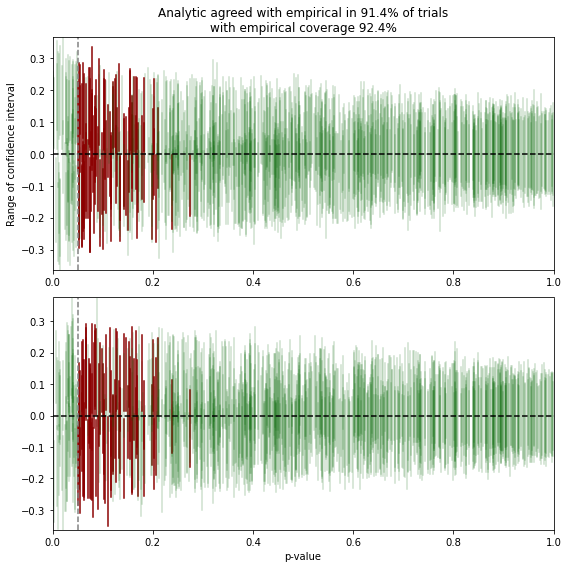

5
p value 0.2052152559537488 and confidence interval(s) [-0.18390229 -0.15596019 -0.29240945 -0.02259888 -0.28433987] to [0.27982038 0.22538666 0.15259399 0.36534676 0.22116879]
Analytic confidence intervals [-0.10199661 -0.10338734 -0.23013301  0.02321136 -0.18549652] to [0.2032908  0.17345961 0.06892905 0.30244333 0.13324894]
p value 0.26527050102104166 and confidence interval(s) [-0.16077746 -0.28634101 -0.28205609 -0.29862821 -0.22935937] to [0.28096518 0.11725868 0.10126237 0.11365307 0.18501538]
Analytic confidence intervals [-0.08047359 -0.22120004 -0.22393681 -0.22958382 -0.16076465] to [0.20208923 0.04888826 0.03927793 0.04339386 0.11290523]
p value 0.42588523988146687 and confidence interval(s) [-0.14977716 -0.22218844 -0.10416357 -0.28053817 -0.274046  ] to [0.21738534 0.17896406 0.3089968  0.06987794 0.14927313]
Analytic confidence intervals [-0.10491514 -0.17314575 -0.03880897 -0.25183447 -0.22176483] to [0.18493282 0.12982157 0.26865936 0.03132633 0.08946052]
p value 0.14

p value 0.0654042787011444 and confidence interval(s) [-0.05705096 -0.24857782 -0.02935141 -0.21514392 -0.15140729] to [0.32735717 0.1871395  0.36042473 0.16677208 0.22015488]
Analytic confidence intervals [-0.00598767 -0.18142073  0.02299854 -0.16428426 -0.10344926] to [0.27547574 0.11823882 0.30642039 0.11626532 0.17327129]
p value 0.4245198411908855 and confidence interval(s) [-0.10956609 -0.07306734 -0.14354558 -0.2661823  -0.20833755] to [0.25042769 0.30997723 0.2462559  0.15756562 0.17015561]
Analytic confidence intervals [-0.06703081 -0.02088846 -0.08600363 -0.2020707  -0.16073081] to [0.20082956 0.25541454 0.19272566 0.08854207 0.11392576]
p value 0.10305557955117994 and confidence interval(s) [-0.23423849 -0.14296772 -0.32283595 -0.21468709 -0.18649903] to [0.20614073 0.22996482 0.02302718 0.07713421 0.23192666]
Analytic confidence intervals [-0.14043645 -0.07642718 -0.26347344 -0.20082472 -0.10263452] to [ 0.11685344  0.16034161 -0.03545947  0.06284963  0.14816026]
p value 0.

p value 0.19225842630134093 and confidence interval(s) [-0.23341565 -0.07746745 -0.17208698 -0.19496949 -0.21134894] to [0.04621751 0.28380427 0.09786049 0.16249245 0.0799264 ]
Analytic confidence intervals [-0.21731155 -0.0130844  -0.16120532 -0.13013773 -0.18944166] to [0.03398717 0.21380435 0.0857029  0.09555152 0.06703497]
p value 0.6188068127429861 and confidence interval(s) [-0.16479744 -0.20436887 -0.07024164 -0.14698833 -0.24422888] to [0.20202582 0.23131411 0.27787647 0.25947365 0.18866575]
Analytic confidence intervals [-0.11201604 -0.12645924 -0.01913092 -0.07691115 -0.16760019] to [0.14502345 0.15366889 0.23126928 0.19365992 0.11163005]
p value 0.05712949396196987 and confidence interval(s) [-0.0416988  -0.22002108 -0.32086372 -0.11308956 -0.10160196] to [0.29044658 0.23503265 0.09140518 0.26153699 0.29239577]
Analytic confidence intervals [ 0.00545912 -0.13430389 -0.25112391 -0.05547094 -0.05542962] to [0.25545652 0.15831522 0.02739945 0.21003276 0.21685193]
p value 0.7123

p value 0.668044363248151 and confidence interval(s) [-0.19581057 -0.20266502 -0.07226177 -0.0551457  -0.0693571 ] to [0.17679992 0.12157627 0.21094336 0.19477624 0.17964132]
Analytic confidence intervals [-0.12545073 -0.1760712  -0.05709473 -0.05833476 -0.07252698] to [0.11236421 0.10321254 0.20391825 0.18686146 0.17221578]
p value 0.1339504528047204 and confidence interval(s) [-0.11987299 -0.35745949 -0.14785054 -0.24528883 -0.32011488] to [0.27429411 0.08790086 0.22670771 0.17707618 0.03140068]
Analytic confidence intervals [-0.07444799 -0.29195819 -0.10560353 -0.18624473 -0.28412757] to [ 0.2199092   0.02093074  0.1813385   0.11845948 -0.00615191]
p value 0.21400968822904654 and confidence interval(s) [-0.3347412  -0.29479948 -0.16547893 -0.10967133 -0.16638197] to [0.10382787 0.14924586 0.25892386 0.36895418 0.22577918]
Analytic confidence intervals [-0.26334418 -0.22616945 -0.10511224 -0.03198211 -0.11065883] to [0.03518115 0.07421389 0.18855215 0.27987821 0.17163053]
p value 0.8

p value 0.630618538408245 and confidence interval(s) [-0.11894111 -0.28711414 -0.13991022 -0.15772469 -0.17602405] to [0.29087397 0.11903284 0.25102982 0.24718121 0.22954036]
Analytic confidence intervals [-0.06322341 -0.23344357 -0.08976227 -0.10595231 -0.12149237] to [0.23407845 0.06252479 0.20061244 0.18956352 0.17426365]
p value 0.13151112085466088 and confidence interval(s) [-0.2150048  -0.17395738 -0.12863846 -0.06266347 -0.08837681] to [0.20431291 0.10594417 0.2358999  0.31155735 0.29167986]
Analytic confidence intervals [-0.13696647 -0.16979446 -0.06867289  0.00104195 -0.02023315] to [0.1252009  0.09986132 0.17577069 0.24871057 0.22935916]
p value 0.1783552492722319 and confidence interval(s) [-0.23281524 -0.22849432 -0.2057773  -0.32452574 -0.27961931] to [0.13162316 0.17297874 0.16772203 0.08745132 0.06219275]
Analytic confidence intervals [-0.17235529 -0.15792293 -0.14539346 -0.24835227 -0.23009917] to [0.07576862 0.10250336 0.10579605 0.01545882 0.01019888]
p value 0.076449

p value 0.6473618818372578 and confidence interval(s) [-0.14226624 -0.18243504 -0.07711119 -0.22465123 -0.1950032 ] to [0.22185914 0.21368697 0.30876616 0.2735697  0.22419116]
Analytic confidence intervals [-0.09572799 -0.11660023 -0.01727343 -0.12894493 -0.13084471] to [0.16310807 0.15336873 0.24918163 0.17382332 0.14687523]
p value 0.9181048872923037 and confidence interval(s) [-0.19728418 -0.16647123 -0.14595209 -0.21730806 -0.23774193] to [0.19135927 0.27209252 0.24345352 0.20798108 0.16884218]
Analytic confidence intervals [-0.13151068 -0.08364437 -0.08153714 -0.13727483 -0.16318671] to [0.12479826 0.18862853 0.17502302 0.13084578 0.09897136]
p value 0.4784964750827395 and confidence interval(s) [-0.34690163 -0.17897414 -0.22955659 -0.11898602 -0.24542393] to [0.14213604 0.29904398 0.25700325 0.23566994 0.14196013]
Analytic confidence intervals [-0.2547912  -0.06343408 -0.14529882 -0.05878899 -0.18213618] to [0.04258501 0.23057269 0.15132302 0.19445476 0.08253457]
p value 0.080889

p value 0.3660773070315033 and confidence interval(s) [-0.16015434 -0.14334349 -0.07042401 -0.18100888 -0.14129417] to [0.22383653 0.35547385 0.32744625 0.24155147 0.2314401 ]
Analytic confidence intervals [-0.09561166 -0.03296676  0.00295843 -0.09200035 -0.07605183] to [0.16620484 0.26543918 0.26946468 0.18265059 0.18189864]
p value 0.6363413517121562 and confidence interval(s) [-0.33716339 -0.20560212 -0.21440694 -0.12445389 -0.18444927] to [0.1112424  0.25667971 0.17041901 0.3142668  0.21691209]
Analytic confidence intervals [-0.26950989 -0.13449002 -0.1670953  -0.06667698 -0.13542374] to [0.04987573 0.18979972 0.1287822  0.24924064 0.16674363]
p value 0.9353719220987317 and confidence interval(s) [-0.1567452  -0.17608696 -0.24982883 -0.22789691 -0.1960565 ] to [0.2398558  0.27121955 0.14905709 0.19406052 0.26096785]
Analytic confidence intervals [-0.10938667 -0.11223087 -0.20171943 -0.17347889 -0.13021032] to [0.19256171 0.20843923 0.10109752 0.13797241 0.19392437]
p value 0.322663

p value 0.36800107826837614 and confidence interval(s) [-0.2044798  -0.16068195 -0.22350687 -0.04178614 -0.19595088] to [0.18172881 0.25248924 0.2476625  0.31979701 0.26551169]
Analytic confidence intervals [-0.1376292  -0.08969656 -0.13869642  0.01016184 -0.10684203] to [0.12332482 0.18021285 0.1495351  0.26265931 0.17840506]
p value 0.4114178129327606 and confidence interval(s) [-0.28211409 -0.26860553 -0.107949   -0.06003014 -0.14529479] to [0.09076996 0.14358006 0.16926032 0.24875116 0.14573327]
Analytic confidence intervals [-0.21994207 -0.18521864 -0.10662812 -0.04549182 -0.1357105 ] to [0.02602012 0.07338098 0.160356   0.23628613 0.13784717]
p value 0.4046181764380903 and confidence interval(s) [-0.27813694 -0.27557579 -0.10897388 -0.14794886 -0.16492899] to [0.17183475 0.06982839 0.30866125 0.2195324  0.22359303]
Analytic confidence intervals [-0.1766143  -0.23637379 -0.03589433 -0.0984156  -0.1069354 ] to [0.11703658 0.02090415 0.24700848 0.16695714 0.16592879]
p value 0.14170

p value 0.10573291622682068 and confidence interval(s) [-0.26574188 -0.0667188  -0.32731172 -0.21061668 -0.3209064 ] to [0.18905883 0.34006551 0.13280928 0.21290548 0.06938721]
Analytic confidence intervals [-0.18227506 -0.00512165 -0.24080317 -0.13484567 -0.25073027] to [0.10351763 0.26516378 0.04665628 0.14094442 0.0140199 ]
p value 0.32853754453068174 and confidence interval(s) [-0.1489674  -0.26717472 -0.15403341 -0.0275473  -0.08529319] to [0.23943765 0.1235799  0.20036434 0.32683533 0.22605737]
Analytic confidence intervals [-0.09244363 -0.2106771  -0.10366944 -0.01314087 -0.05180838] to [0.17953524 0.06212317 0.15612995 0.3139203  0.191702  ]
p value 0.309456125248466 and confidence interval(s) [-0.20072463 -0.18446016 -0.30071864 -0.31321272 -0.28381777] to [0.21560933 0.21129169 0.05783187 0.15673748 0.1007579 ]
Analytic confidence intervals [-0.1306578  -0.12182439 -0.24773954 -0.22615686 -0.22326019] to [0.14550248 0.14742315 0.0085409  0.06724722 0.0421583 ]
p value 0.44840

p value 0.709999675455729 and confidence interval(s) [-0.1351442  -0.20820932 -0.28364629 -0.17734896 -0.19130178] to [0.23621501 0.19324896 0.05188155 0.18928684 0.23538359]
Analytic confidence intervals [-0.07915033 -0.13806765 -0.27202462 -0.12738888 -0.11379691] to [0.17413484 0.12528206 0.0310691  0.12428034 0.15770102]
p value 0.19671808719684414 and confidence interval(s) [-0.30391914 -0.12333596 -0.26066172 -0.11866592 -0.31000656] to [0.07829566 0.23981693 0.14463116 0.26914293 0.08085725]
Analytic confidence intervals [-0.25379739 -0.06979559 -0.19669179 -0.0651591  -0.24963712] to [0.01977736 0.19687    0.08502111 0.21041033 0.02701561]
p value 0.904072395559706 and confidence interval(s) [-0.15520395 -0.15219875 -0.21703716 -0.17357795 -0.25688797] to [0.23361191 0.29975745 0.15439175 0.18145795 0.23566349]
Analytic confidence intervals [-0.09371022 -0.07002846 -0.16137078 -0.1228506  -0.15893189] to [0.17493462 0.21960896 0.10119876 0.1338593  0.14343366]
p value 0.5774776

p value 0.2975280212271597 and confidence interval(s) [-0.12925795 -0.13283144 -0.20877017 -0.05589903 -0.16932136] to [0.25182855 0.24714915 0.16681573 0.38189095 0.23817563]
Analytic confidence intervals [-0.08350095 -0.0881847  -0.16328211  0.00741616 -0.11464919] to [0.20776796 0.20266124 0.12587703 0.31960344 0.18654356]
p value 0.854312210259115 and confidence interval(s) [-0.20835476 -0.18969962 -0.22669728 -0.14625725 -0.12719022] to [0.27203843 0.24904333 0.14362472 0.21031857 0.26472977]
Analytic confidence intervals [-0.1137026  -0.11174663 -0.19212689 -0.10136723 -0.06742146] to [0.19492976 0.18320318 0.07885035 0.16453318 0.21134581]
p value 0.838488807728252 and confidence interval(s) [-0.15402155 -0.18032554 -0.28856358 -0.15584001 -0.17780669] to [0.27279982 0.27582186 0.17111866 0.19448188 0.20648003]
Analytic confidence intervals [-0.07071138 -0.08967258 -0.19520018 -0.10893863 -0.10696133] to [0.20526803 0.19563037 0.09120601 0.14108856 0.15490596]
p value 0.72602448

p value 0.13756120190527688 and confidence interval(s) [-0.23466022 -0.29070923 -0.1235933  -0.27554381 -0.34533241] to [0.12661105 0.1977144  0.27694955 0.13577071 0.04101828]
Analytic confidence intervals [-0.18140044 -0.21602231 -0.05617792 -0.20720156 -0.28665449] to [ 0.07223688  0.07889126  0.21088952  0.06343316 -0.02436115]
p value 0.6310415685599929 and confidence interval(s) [-0.22015986 -0.24957651 -0.27577344 -0.05867204 -0.27962035] to [0.17314976 0.16019148 0.13595954 0.27680144 0.17334823]
Analytic confidence intervals [-0.18109382 -0.21021147 -0.23175138 -0.03850458 -0.22182882] to [0.13883935 0.11634704 0.09558925 0.25697071 0.12151249]
p value 0.06723567609484238 and confidence interval(s) [-0.28039002 -0.21393228 -0.2080451  -0.13237874 -0.31779262] to [0.10627323 0.05296004 0.09447227 0.28471452 0.05430156]
Analytic confidence intervals [-0.21016538 -0.21303199 -0.19611929 -0.04378487 -0.25276866] to [ 0.03656686  0.04503204  0.07862872  0.2124723  -0.01072937]
p va

KeyboardInterrupt: 

In [8]:
#%%time
bmean, bstd = 0,0
reps = 1000

for d in [2, 5, 10]:
    print(d)
    if d == 1:
        print("We don't allow d=1 because it changes the return type of the subplots function >.<")
    equiv = []
    pVals = []
    lcbs = []
    ucbs = []

    betas = []
    covered = []

    for i in range(reps):
        beta = np.array(np.random.normal(loc=bmean,scale=bstd, size=d))
        s, p, l, u = compareAnalyticVsOptimization(beta=beta)
        equiv.append(s)
        pVals.append(p)
        lcbs.append(l)
        ucbs.append(u)

        betas.append(beta)
        covered.append((l<=beta) & (beta<=u))
    
    print("Coverage for analytic CIs (non-GLRT):", np.mean(covered_a))
    print("Coverage for empirical CI's (GLRT):", np.mean(covered))
    
    fig, ax = plt.subplots(d, figsize=(8, 4*d))
    for i in range(d):
        ilcbs = [l[i] for l in lcbs]
        iucbs = [u[i] for u in ucbs]
        minY = min(ilcbs)
        maxY = max(iucbs)
        ax[i].set_ylim(minY, maxY)

        for (p, l, u, s) in zip(pVals, ilcbs, iucbs, equiv):
            # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
            ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                        color=('darkgreen' if s else 'darkred'), alpha=(0.2 if s else 1))  # display mismatches in a darker line

        ax[i].axhline(0, color='k', linestyle='--')
        ax[i].axvline(0.05, color='gray', linestyle='--')

    ax[0].set_title("Analytic agreed with empirical in " + str(np.mean(equiv)*100) + "% of trials\nwith empirical coverage "+str(np.mean(covered)*100)+"%")    
    ax[d-1].set_xlabel("p-value")
    ax[0].set_ylabel("Range of confidence interval")
    plt.tight_layout()
    
    plt.savefig("trueZero-dim"+str(d)+".png")
    plt.show()

## Multidimensional Nonzero Coefficient

In [ ]:
%%time
bmean, bstd = 0,1
reps = 1000

for d in [2, 5, 10]:
    if d == 1:
        print("We don't allow d=1 because it changes the return type of the subplots function >.<")
    equiv = []
    pVals = []
    lcbs = []
    ucbs = []

    betas = []
    covered = []

    for i in range(reps):
        beta = np.array(np.random.normal(loc=bmean,scale=bstd, size=d))
        s, p, l, u = compareAnalyticVsOptimization(beta=beta)
        equiv.append(s)
        pVals.append(p)
        lcbs.append(l)
        ucbs.append(u)

        betas.append(beta)
        covered.append((l<=beta) & (beta<=u))
    
    fig, ax = plt.subplots(d, figsize=(8, 4*d))
    for i in range(d):
        ilcbs = [l[i] for l in lcbs]
        iucbs = [u[i] for u in ucbs]
        minY = min(ilcbs)
        maxY = max(iucbs)
        # For some reason this isn't working?
        ax[i].set_ylim(minY, maxY)

        for (p, l, u, s) in zip(pVals, ilcbs, iucbs, equiv):
            # ymin and ymax are the 'fraction of the way up from the bottom of the plot'
            ax[i].axvline(x=p, ymin=(l-minY)/(maxY - minY), ymax=(u-minY)/(maxY-minY),
                        color=('darkgreen' if s else 'darkred'), alpha=(0.2 if s else 1))  # display mismatches in a darker line

        ax[i].axhline(0, color='k', linestyle='--')
        ax[i].axvline(0.05, color='gray', linestyle='--')

    ax[0].set_title("Analytic agreed with empirical in " + str(np.mean(equiv)*100) + "% of trials\nwith empirical coverage "+str(np.mean(covered)*100)+"%")    
    ax[d-1].set_xlabel("p-value")
    ax[0].set_ylabel("Range of confidence interval")
    plt.tight_layout()
    
    plt.savefig("trueNonZero-dim"+str(d)+".png")
    plt.show()